In [1]:
import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


## 📚 Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
import lightgbm as lgb
import optuna
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 📥 Load Data

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s5e5/train.csv")

test = pd.read_csv("/kaggle/input/playground-series-s5e5/test.csv")

## 🧹 Data Cleaning: Missing Values | Data Types

In [4]:
# Function to display missing values and data types
def check_missing_and_dtypes(df, name="Dataset"):
    print(f"\n{name} Info:")
    print("-" * 50)
    nulls = df.isnull().sum()
    dtypes = df.dtypes
    summary = pd.DataFrame({
        "Data Type": dtypes,
        "Missing Values": nulls,
        "Missing (%)": (nulls / len(df)) * 100
    })
    print(summary)
    return summary


train_info = check_missing_and_dtypes(train, "Train Set")
test_info = check_missing_and_dtypes(test, "Test Set")


Train Set Info:
--------------------------------------------------
           Data Type  Missing Values  Missing (%)
id             int64               0          0.0
Sex           object               0          0.0
Age            int64               0          0.0
Height       float64               0          0.0
Weight       float64               0          0.0
Duration     float64               0          0.0
Heart_Rate   float64               0          0.0
Body_Temp    float64               0          0.0
Calories     float64               0          0.0

Test Set Info:
--------------------------------------------------
           Data Type  Missing Values  Missing (%)
id             int64               0          0.0
Sex           object               0          0.0
Age            int64               0          0.0
Height       float64               0          0.0
Weight       float64               0          0.0
Duration     float64               0          0.0
Heart_Rate   fl

## 📊 EDA: Description | Visualization


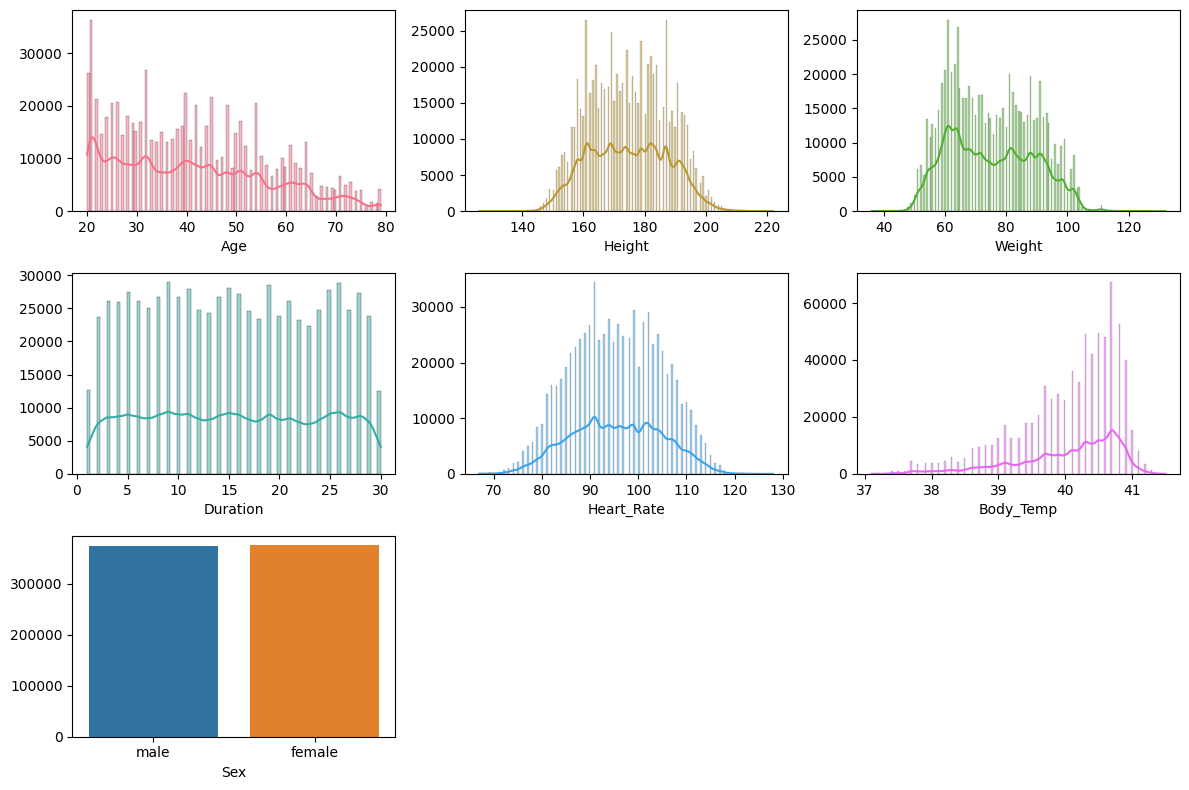

In [5]:
#univariate distribution of the features.
col = ["Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp"]
colors = sb.color_palette("husl", len(col))

fig, axes = plt.subplots(3, 3, figsize=(12, 8))  
axes = axes.flatten()


for i in range(len(col)):
    sb.histplot(train[col[i]], kde=True, ax=axes[i], color=colors[i])
    axes[i].set_ylabel("")


sb.countplot(x='Sex', data=train, ax=axes[len(col)])
axes[len(col)].set_ylabel("")


for j in range(len(col) + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

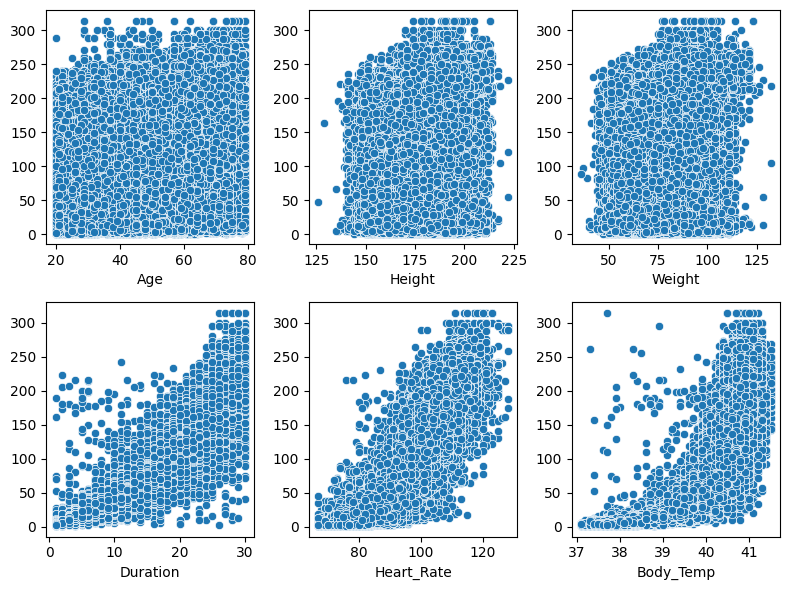

In [6]:
#relationship between numeric features and calories burned
col = ["Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp"]


fig, axes = plt.subplots(2,3, figsize = (8, 6) )

axes = axes.flatten()

for i in range(len(axes)):
    if i < len(col):
        sb.scatterplot(x = col[i], y = 'Calories', data = train, ax = axes[i])
        axes[i].set_ylabel("")
    else:
        fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

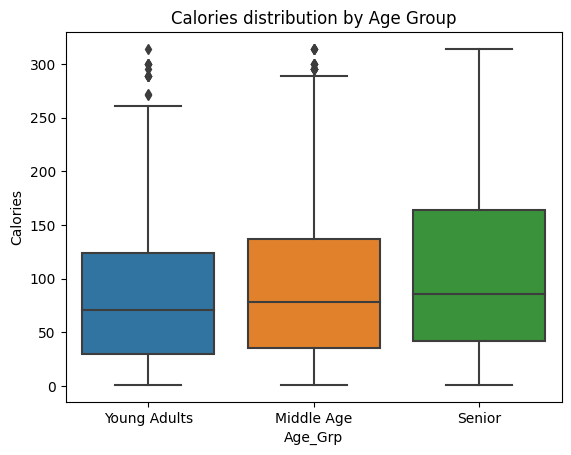

In [7]:
#create categorical grouping for age
bins = [20, 35, 55, 80]
labels = ['Young Adults', 'Middle Age', 'Senior']

train['Age_Grp'] = pd.cut(train['Age'], bins = bins, labels = labels, right = True, include_lowest = True)



sb.boxplot(x='Age_Grp', y='Calories', data=train)
plt.title('Calories distribution by Age Group')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_35/3143058817.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


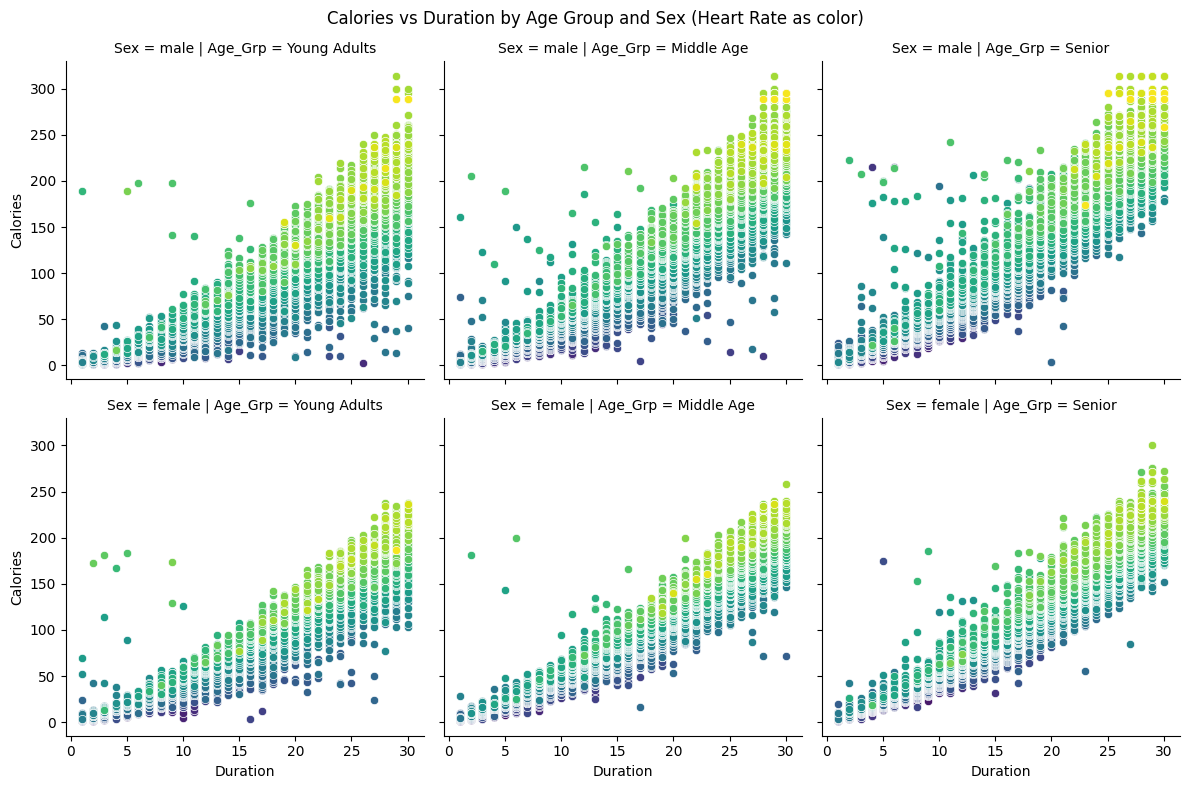

In [8]:

g = sb.FacetGrid(train, col="Age_Grp", row="Sex", hue="Heart_Rate", palette="viridis", height=4)
g.map(sb.scatterplot, "Duration", "Calories")

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Calories vs Duration by Age Group and Sex (Heart Rate as color)')

plt.tight_layout()
plt.show()

## 🏗️ Feature Engineering

In [9]:
def feature_engineering(df):
    df['Intensity_Index'] = df['Heart_Rate'] / df['Duration']
    
    df['Age'] = np.log1p(df['Age'])
    df['Body_Temp'] = np.log1p(df['Body_Temp'])

    df['BMR'] = (
        10 * df['Weight'] + 
        6.25 * df['Height'] - 
        5 * df['Age'] + 
        np.where(df['Sex'] == 'male', 5, -161)
    )

    # Core interactions
    df['HR_Temp_Interaction'] = df['Heart_Rate'] * df['Body_Temp']
    df['HR_Duration_Interaction'] = df['Heart_Rate'] * df['Duration']
    df['Metabolic_Load'] = df['Heart_Rate'] * df['Body_Temp'] * df['Duration']  
    df['Age_Duration'] = df['Age'] * df['Duration']
    df['Age_Body_Temp'] = df['Age'] * df['Body_Temp']
    df['Duration_Body_Temp'] = df['Duration'] * df['Body_Temp']
    df['Age_Duration_Temp'] = df['Age'] * df['Duration'] * df['Body_Temp']

    # Height & Weight interactions 
    df['Height_Weight'] = df['Height'] * df['Weight']
    df['Height_Duration'] = df['Height'] * df['Duration']
    df['Weight_Duration'] = df['Weight'] * df['Duration']
    df['Weight_HeartRate'] = df['Weight'] * df['Heart_Rate']
    df['Weight_BodyTemp'] = df['Weight'] * df['Body_Temp']
    df['Height_Temp_Interaction'] = df['Height'] * df['Body_Temp']
    df['Weight_Duration_Temp'] = df['Weight'] * df['Duration'] * df['Body_Temp']
    df['Height_Duration_Temp'] = df['Height'] * df['Duration'] * df['Body_Temp']
    df['Weight_HR_Duration'] = df['Weight'] * df['Heart_Rate'] * df['Duration']
    df['Height_HR_Duration'] = df['Height'] * df['Heart_Rate'] * df['Duration']

    # Advanced exertion interactions
    df['Weight_Intensity_Index'] = df['Weight'] * df['Intensity_Index']
    df['Height_Intensity_Index'] = df['Height'] * df['Intensity_Index']
    df['Weight_HR_Temp_Interaction'] = df['Weight'] * df['HR_Temp_Interaction']
    df['Height_HR_Temp_Interaction'] = df['Height'] * df['HR_Temp_Interaction']

    # Log transform Calories only for training set
    if 'Calories' in df.columns:
        df['Calories'] = np.log1p(df['Calories'])

    return df


# Apply to both datasets
train = feature_engineering(train)
test = feature_engineering(test)

## 🤖 Model Selection | Training

In [10]:
# Encode 'Sex' to numeric values
train['Sex'] = train['Sex'].map({'male': 1, 'female': 0}).astype(int)
test['Sex'] = test['Sex'].map({'male': 1, 'female': 0}).astype(int)

In [11]:
test_df = test.drop(['id'], axis = 1)

x = train.drop(['Calories', 'id', 'Age_Grp'], axis = 1)
y = train['Calories']

In [12]:
#split x and y into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 4)

In [13]:
## Define custom RMSLE metric
def rmsle(y_val_log, y_pred_log):
    y_val = np.expm1(y_val_log)
    y_pred = np.expm1(y_pred_log)
    preds = np.maximum(0, y_pred)
    return np.sqrt(mean_squared_log_error(y_val, preds))


def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 2000, 7000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 6, 16),  
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 100, log = True),
        'grow_policy': 'SymmetricTree',
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'random_seed': 34,
        'early_stopping_rounds': 100,
        'use_best_model': True,
        'verbose': 0
    }


    train_pool = Pool(data=x_train, label=y_train)
    valid_pool = Pool(data=x_val, label=y_val)


    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=valid_pool)


    preds = model.predict(valid_pool)
    score = rmsle(y_val, preds)
    return score

In [14]:
cat_model = CatBoostRegressor(
    iterations = 4788,
    learning_rate = 0.021048601257810478,
    l2_leaf_reg = 2.211703712973945,
    grow_policy = 'SymmetricTree',
    loss_function = 'RMSE', 
    eval_metric='RMSE',
    random_seed = 34,
    depth = 14,
    verbose = 0
)

cat_model.fit(x_train, y_train)

In [15]:
cat_pred = cat_model.predict(x_val)

cat_pred = np.expm1(cat_pred)
y_val = np.expm1(y_val)

rmsle = np.sqrt(mean_squared_log_error(cat_pred, y_val))

In [16]:
rmsle

0.05984366486518475

In [17]:
feature_importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': cat_model.get_feature_importance()
}).sort_values(by='Importance', ascending=False)

# Display all features
print(feature_importance_df.to_string(index=False))


                   Feature  Importance
            Metabolic_Load   17.818920
   HR_Duration_Interaction   12.768028
         Age_Duration_Temp   10.737363
              Age_Duration   10.053327
       HR_Temp_Interaction    7.402674
                Heart_Rate    7.184909
             Age_Body_Temp    5.368942
                  Duration    4.385835
                       Sex    4.234880
        Duration_Body_Temp    3.825440
                       Age    3.689023
        Height_HR_Duration    3.612565
           Intensity_Index    1.152062
Height_HR_Temp_Interaction    0.959461
                       BMR    0.949366
                 Body_Temp    0.797079
           Height_Duration    0.618527
             Height_Weight    0.553520
      Height_Duration_Temp    0.519664
Weight_HR_Temp_Interaction    0.435854
           Weight_BodyTemp    0.431713
                    Weight    0.409222
   Height_Temp_Interaction    0.403859
          Weight_HeartRate    0.367265
        Weight_HR_Duratio

In [19]:
# Make final predictions on the test dataset 
final_pred = cat_model.predict(test_df)

# Convert back from log scale
final_pred = np.expm1(final_pred)


final_pred = np.maximum(0, final_pred)


submission = pd.DataFrame({
    'id': test['id'],
    'Calories': final_pred
})
submission.to_csv('submission.csv', index=False)


In [21]:
from IPython.display import FileLink
FileLink('submission.csv')

/kaggle/working/submission.csv